In [6]:
import numpy
import pandas
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import trange

Using TensorFlow backend.


In [1]:
def load_dataset(datasource):
    # load the dataset
    dataframe = pandas.read_csv(datasource, usecols=[1])
    dataframe = dataframe.fillna(method='pad')
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    plt.plot(dataset)
    plt.show()

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

In [2]:
def create_dataset(dataset, look_back=1):
    # `look_back`, which is the number of previous time steps to use as input variables 
    # to predict the next time period — in this case defaulted to 1.
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])
    # Return  tuple of input and output dataset
    return numpy.array(data_x), numpy.array(data_y)


In [4]:
def split_dataset(dataset, train_size, look_back):
    # Splits dataset into training and test datasets. The last `look_back` rows in train dataset
    # will be used as `look_back` for the test dataset.
    if not train_size > look_back:
        raise ValueError('train_size must be lager than look_back')
    train, test = dataset[0:train_size, :], dataset[train_size - look_back:len(dataset), :]
    print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    # return: tuple of training data and test dataset
    return train, test


In [7]:
def build_model(look_back: int, batch_size: int=1) -> Sequential:
    model = Sequential()
    model.add(LSTM(64,
                   activation='relu',
                   batch_input_shape=(batch_size, look_back, 1),
                   stateful=True,
                   return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # return: keras Sequential model
    return model


In [8]:
def plot_data(dataset, look_back, train_predict, test_predict,forecast_predict):
    """
    Plots baseline and predictions.
    blue: baseline
    green: prediction with training data
    red: prediction with test data
    cyan: prediction based on predictions
    """
    plt.plot(dataset)
    plt.plot([None for _ in range(look_back)] +
             [x for x in train_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [x for x in test_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [None for _ in test_predict] +
             [x for x in forecast_predict])
    plt.show()


In [9]:
def make_forecast(model, look_back_buffer, timesteps = 1, batch_size = 1):
    forecast_predict = numpy.empty((0, 1), dtype=numpy.float32)
    for _ in trange(timesteps, desc='predicting data\t', mininterval=1.0):
        # make prediction with current lookback buffer
        cur_predict = model.predict(look_back_buffer, batch_size)
        # add prediction to result
        forecast_predict = numpy.concatenate([forecast_predict, cur_predict], axis=0)
        # add new axis to prediction to make it suitable as input
        cur_predict = numpy.reshape(cur_predict, (cur_predict.shape[1], cur_predict.shape[0], 1))
        # remove oldest prediction from buffer
        look_back_buffer = numpy.delete(look_back_buffer, 0, axis=1)
        # concat buffer with newest prediction
        look_back_buffer = numpy.concatenate([look_back_buffer, cur_predict], axis=1)
    return forecast_predict


In [10]:
def main():
    datasource = '../Data/international-airline-passengers.csv'
    dataset, scaler = load_dataset(datasource)

    # split into train and test sets
    look_back = int(len(dataset) * 0.20)
    train_size = int(len(dataset) * 0.70)
    train, test = split_dataset(dataset, train_size, look_back)

    # reshape into X=t and Y=t+1
    train_x, train_y = create_dataset(train, look_back)
    test_x, test_y = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    train_x = numpy.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = numpy.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

    # create and fit Multilayer Perceptron model
    batch_size = 1
    model = build_model(look_back, batch_size=batch_size)
    for _ in trange(100, desc='fitting model\t', mininterval=1.0):
        model.fit(train_x, train_y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

    # generate predictions for training
    train_predict = model.predict(train_x, batch_size)
    test_predict = model.predict(test_x, batch_size)

    # generate forecast predictions
    forecast_predict = make_forecast(model, test_x[-1::], timesteps=100, batch_size=batch_size)

    # invert dataset and predictions
    dataset = scaler.inverse_transform(dataset)
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform([train_y])
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform([test_y])
    forecast_predict = scaler.inverse_transform(forecast_predict)

    # calculate root mean squared error
    train_score = numpy.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
    print('Train Score: %.2f RMSE' % train_score)
    test_score = numpy.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
    print('Test Score: %.2f RMSE' % test_score)

    plot_data(dataset, look_back, train_predict, test_predict, forecast_predict)


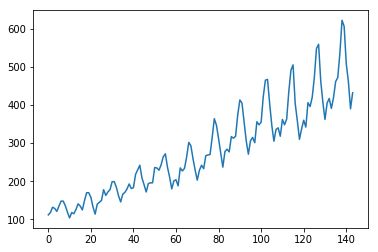

train_dataset: 100, test_dataset: 72


predicting data	: 100%|████████████████████████████████| 100/100 [00:00<00:00, 228.64it/s]


Train Score: 16.02 RMSE
Test Score: 43.96 RMSE


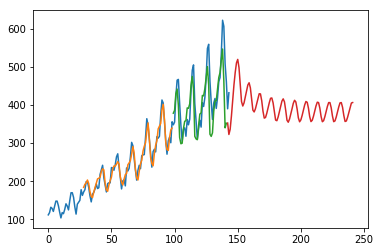

In [13]:
main()

In [12]:
model

NameError: name 'model' is not defined